In [1]:
# import dependencies
# import sys
# !{sys.executable} -m pip install seaborn
import matplotlib as mplt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import glacierml as gl
import numpy as np
import warnings
from tensorflow.python.util import deprecation
import os
import logging
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
import geopy
from sklearn.cluster import KMeans
import glacierml as gl

# display(HTML("<style>.container { width:85% !important; }</style>"))
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
deprecation._PRINT_DEPRECATION_WARNINGS = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.set_option('display.max_columns', None)

pd.set_option('mode.chained_assignment', None)

RS = range(0,25,1)

print('currently running tensorflow version: ' + tf.__version__)

2022-08-29 15:46:20.412888: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


currently running tensorflow version: 2.9.1


# ML Analysis

In [93]:
# select dataset to analyze

selected_dataset = 'df9'

if selected_dataset == 'df1':
    df1 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'n'
    )
    module = 'sm1'
    res = 'sr1'
    dataset = df1
    dataset.name = selected_dataset
if selected_dataset == 'df2':
    df2 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df2 = df2.drop(['region'], axis = 1)
    module = 'sm2'
    res = 'sr2'
    dataset = df2
    dataset.name = selected_dataset
if selected_dataset == 'df3':
    df3 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 1
    )
    df3 = df3.drop(['RGIId', 'region'], axis = 1)
    module = 'sm3'
    res = 'sr3'
    dataset = df3
    dataset.name = 'df3'
if selected_dataset == 'df4':
    df4 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'on',
        anomaly_input = 5
    )
    df4 = df4.drop(['RGIId', 'region'], axis = 1)
    module = 'sm4'
    res = 'sr4'
    dataset = df4
    dataset.name = 'df4'
if selected_dataset == 'df5':
    df5 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'g',
        area_scrubber = 'off'
    )
    df5 = df5.drop(['Zmed', 'region'], axis = 1)
    dataset = df5
    dataset.name = selected_dataset
    module = 'sm5'
    res = 'sr5'
if selected_dataset == 'df6':
    df6 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
        RGI_input = 'y',
        scale = 'r',
        region_selection = 1,
        area_scrubber = 'off'
    )
    module = 'sm6'
    res = 'sr6'
    reg = df6['region'].iloc[-1]
    df6 = df6.drop('region', axis=1)
    dataset = df6 
    dataset.name = str('df6_' + str(reg))
if selected_dataset == 'df7':
    df7 = gl.data_loader(
#         root_dir = '/home/simonhans/data/prethicktor/',
    )
    df7 = df7.drop(['region'], axis = 1)
    module = 'sm7'
    res = 'sr7'
    dataset = df7 
    dataset.name = 'df7'
if selected_dataset == 'df8':
    df8 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 1
    )
    df8 = df8.drop(['RGIId','Zmed', 'region'], axis = 1)
    module = 'sm8'
    res = 'sr8'
    dataset = df8 
    dataset.name = 'df8'
if selected_dataset == 'df9':
    df9 = gl.data_loader(
        area_scrubber = 'on',
        anomaly_input = 1
    )
    df9 = df9.drop(['RGIId','region'], axis = 1)
    df9['Zdelta'] = df9['Zmax'] - df9['Zmin']
    module = 'sm9'
    res = 'sr9'
    dataset = df9 
    dataset.name = 'df9'

In [100]:
# calculate model parameters 
total_inputs = (len(dataset) * (len(dataset.columns) -1))
inputs = len(dataset.columns) - 1
print('total inputs = ' + str(total_inputs))
print('1/2 inputs = ' + str(0.5 * total_inputs))
non_trainable_parameters = (len(dataset.columns)) + ((len(dataset.columns) - 1))
print('non-trainable parameters = ' + str(non_trainable_parameters))

layer_1 = 60
layer_2 = 30

total_parameters = (
    layer_1 * (inputs + 1)  + 
    (layer_2 * (layer_1 + 1)) + 
    ((1 * (layer_2 + 1))) +
    non_trainable_parameters
)
print('trainable parameters = ' + str(total_parameters - non_trainable_parameters))

total inputs = 2560
1/2 inputs = 1280.0
non-trainable parameters = 21
trainable parameters = 2521


In [85]:
# load deviations table 
rootdir = 'zults/'
predictions = pd.DataFrame()
deviations = pd.DataFrame()

for file in tqdm(os.listdir(rootdir)):
    if 'predictions' in file:
        file_reader = pd.read_csv(rootdir + file)
        predictions = predictions.append(file_reader, ignore_index = True)
    if 'deviations' in file:
        file_reader = pd.read_csv(rootdir + file)
        deviations = pd.concat([deviations, file_reader], ignore_index = True)
        
deviations = deviations.drop('Unnamed: 0', axis = 1)
predictions = predictions.drop('Unnamed: 0', axis = 1)
deviations['total parameters'] = deviations['total parameters'].astype(int)
deviations['trained parameters'] = deviations['trained parameters'].astype(int)
deviations['total inputs'] = deviations['total inputs'].astype(int)
deviations = deviations[
    (deviations['df'].str.contains(selected_dataset)) 
#     &
#     (deviations['layer architecture'] == '10-5')
#     &
#     (deviations['learning rate'] == 0.100)
#     &
#     (deviations['epochs'] == 50)
]
deviations['test - train'] = (
    abs(deviations['test mae avg'] - deviations['train mae avg'])
)
deviations = deviations.sort_values(
    [
#         'layer architecture',
#         'test - train',
#         'epochs',
#         'test mae avg', 
        'test mae avg'
#         'test predicted thickness std dev'
#         'layer architecture',
#         'learning rate',
#         'df',
#         'layer architecture'
    ]
)
deviations

100%|██████████| 142/142 [00:00<00:00, 1990.38it/s]


,layer architecture,total parameters,trained parameters,total inputs,df,dropout,learning rate,validation split,epochs,test mae avg,train mae avg,test mae std dev,train mae std dev,test predicted thickness std dev,train predicted thickness std dev,test - train
60,64-36,3036,3017,3015,df4,1,0.100,0.2,100,11.080989,11.544126,2.010353,0.736424,2.857958,2.940768,0.463137
69,64-36,3036,3017,3015,df4,0,0.100,0.2,100,11.399094,11.863335,2.018775,0.901718,4.504397,3.166286,0.464241
57,47-21,1519,1500,3015,df4,1,0.100,0.2,100,11.526725,12.197646,1.478282,0.932739,4.362331,3.161214,0.670922
66,47-21,1519,1500,3015,df4,0,0.100,0.2,100,11.604664,11.824406,1.811574,0.818223,3.915489,3.168769,0.219741
61,64-36,3036,3017,3015,df4,1,0.010,0.2,100,11.956632,12.372055,2.213204,0.687415,2.463803,1.332494,0.415423
70,64-36,3036,3017,3015,df4,0,0.010,0.2,100,11.997194,12.449057,2.155783,0.697167,2.287080,1.406826,0.451864
67,47-21,1519,1500,3015,df4,0,0.010,0.2,100,12.253505,12.647287,2.211816,0.666966,2.248959,1.186859,0.393782
58,47-21,1519,1500,3015,df4,1,0.010,0.2,100,12.267143,12.584399,2.368182,0.634647,2.208943,1.152919,0.317256
63,10-5,180,161,3015,df4,0,0.100,0.2,100,12.470588,12.908506,2.065852,0.699189,3.936980,2.336457,0.437919
64,10-5,180,161,3015,df4,0,0.010,0.2,100,12.625997,12.961178,2.400555,0.754815,2.180521,0.834023,0.335181


Please select index from deviations table to inspect further
111
60-46
0.1
100
1


25it [00:07,  3.28it/s]


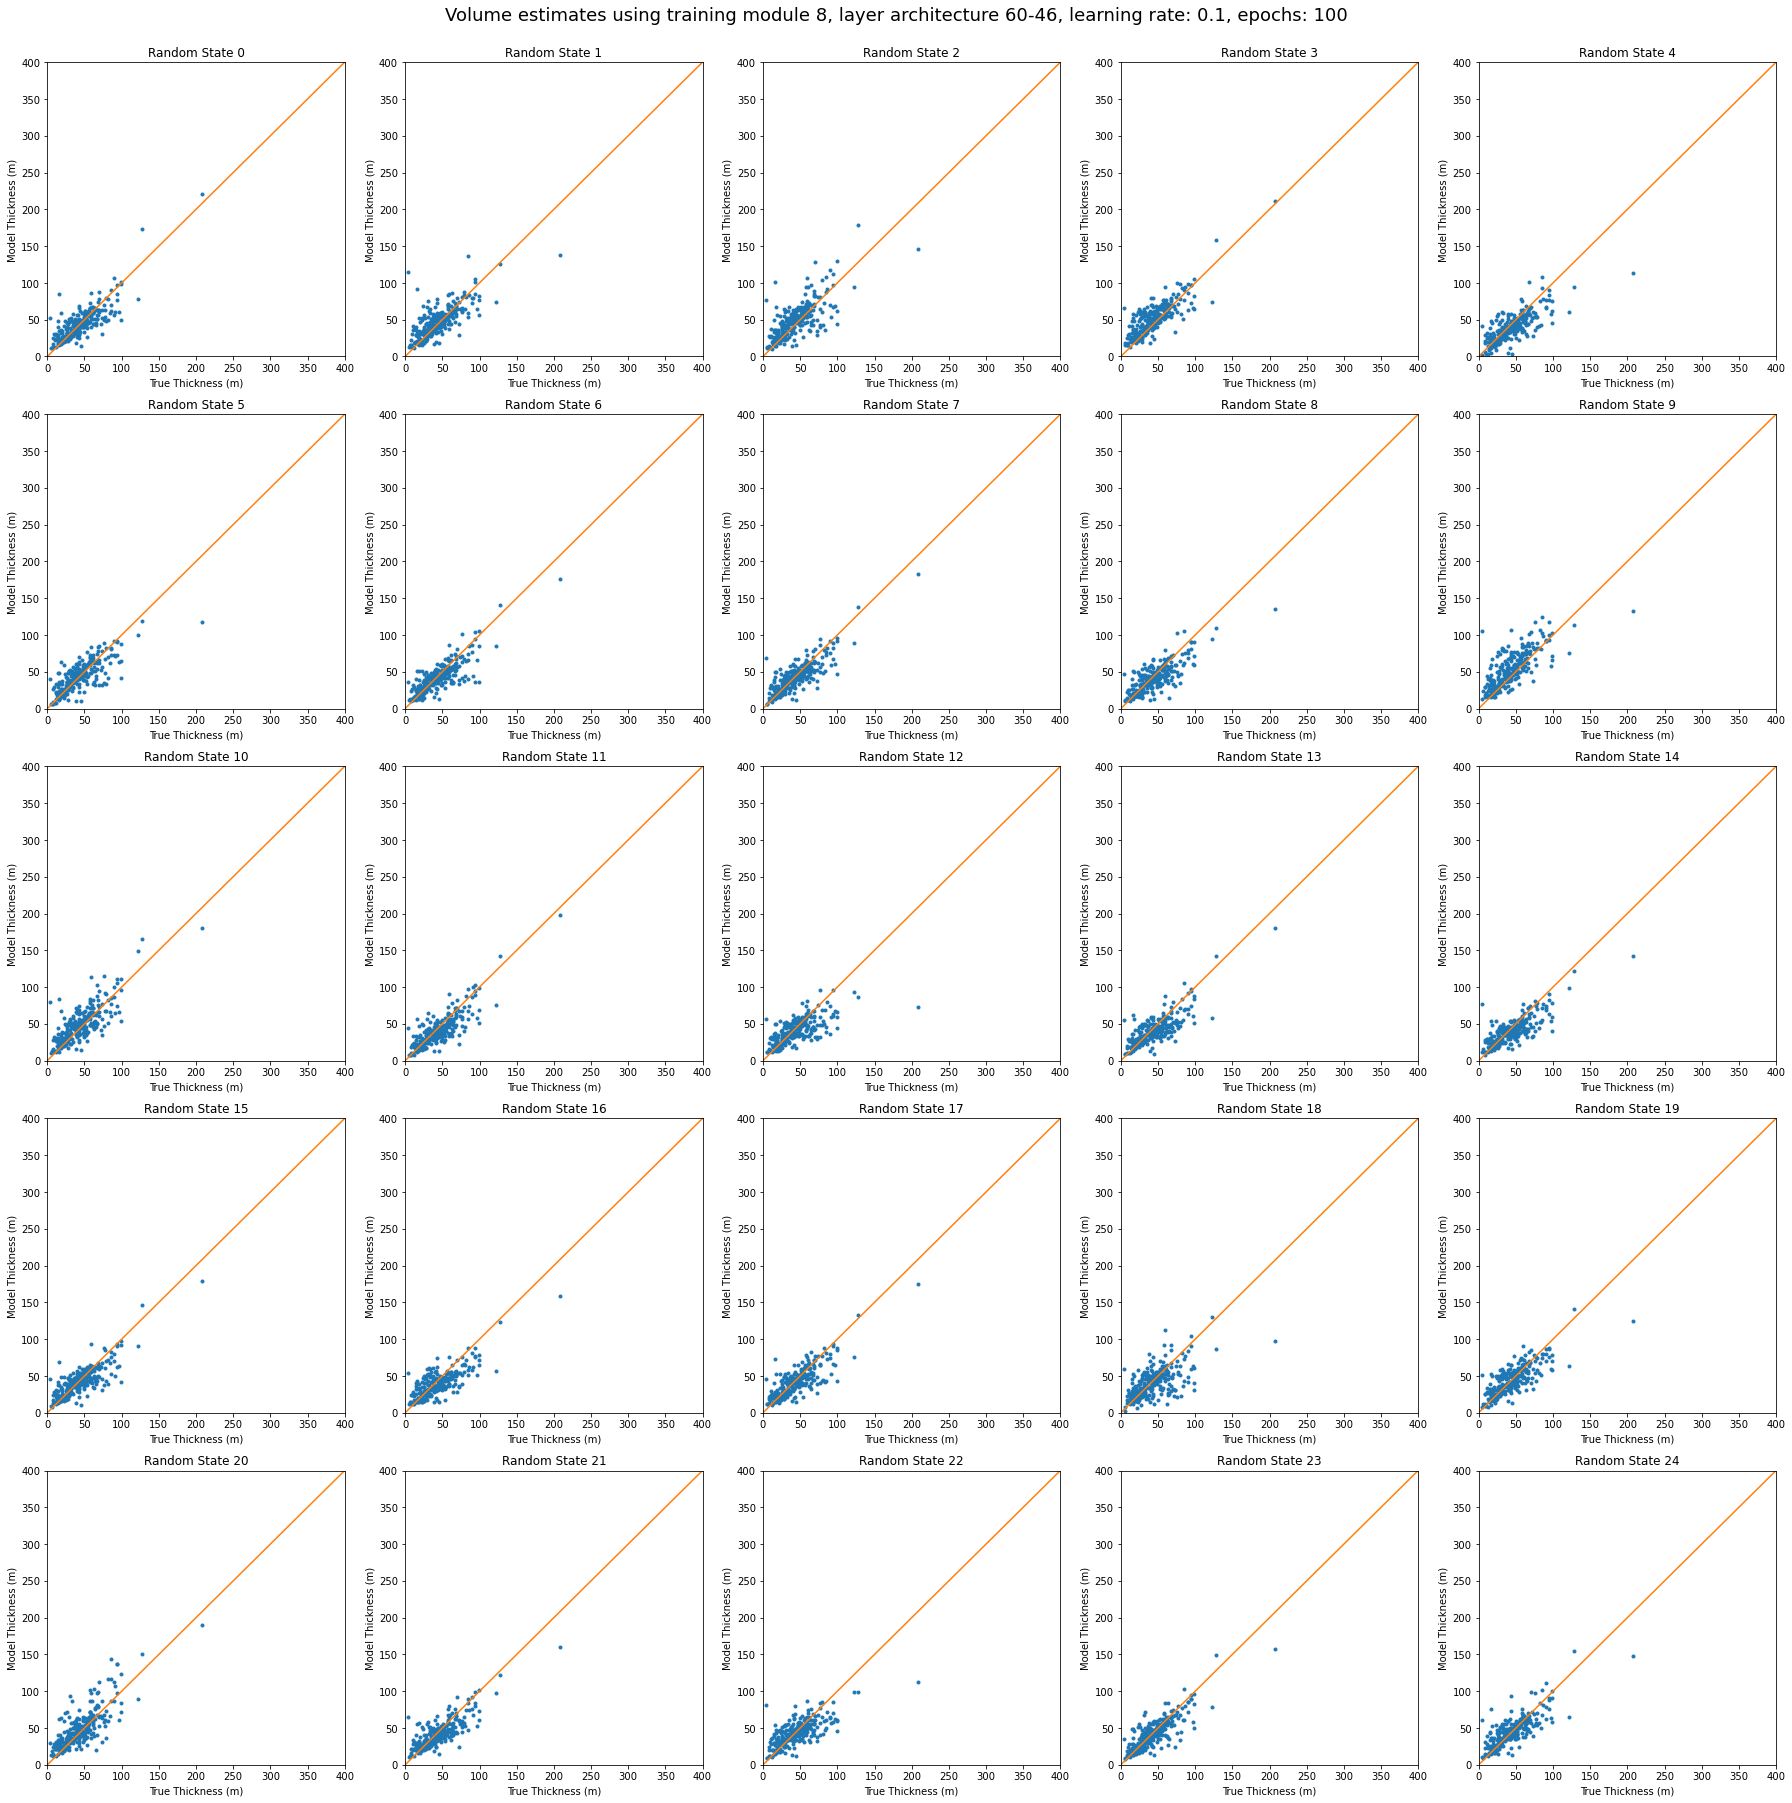

In [78]:
# load selected model and look at predicted accuracies of each random state
print('Please select index from deviations table to inspect further')

selection = int(input())

arch = deviations['layer architecture'].loc[selection]
top_learning_rate = deviations['learning rate'].loc[selection]
epochs = deviations['epochs'].loc[selection]
dropout = deviations['dropout'].loc[selection]
training_module = deviations['df'].loc[selection][2:3]
print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

dnn_model = {}
rootdir = 'saved_models/' + module + '/sm_' + arch + '/'


train_features, test_features, train_labels, test_labels = gl.data_splitter(dataset)
features = pd.concat([train_features, test_features], ignore_index = True)
labels = pd.concat([train_labels, test_labels], ignore_index = True)

fig = plt.figure(figsize=(25, 25))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(
    'Volume estimates using training module ' + training_module +
    ', layer architecture ' + arch +
    ', learning rate: ' + str(top_learning_rate) + ', epochs: ' + str(epochs)
             , fontsize=18, y=1
            )
fig.patch.set_facecolor('w')

for n, rs in tqdm(enumerate(RS)):
    ax = plt.subplot(5, 5, n + 1)
    model_name = (
        str(arch) + 
        '_' + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )   
    
    model_path = (
        rootdir + 
        dataset.name +
        '_' + 
        str(dropout) +
        '_dnn_MULTI_' + 
        str(top_learning_rate) + 
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_model[model_name] = tf.keras.models.load_model(model_path)
    
    
    y = dnn_model[model_name].predict(features, verbose = 0)
    plt.plot(labels,y,'.')
    plt.plot((0,400),(0,400),'-')
    plt.xlabel('True Thickness (m)')
    plt.ylabel('Model Thickness (m)')
    ax.set_title('Random State ' +str(rs))
    plt.xlim((0,400))
    plt.ylim((0,400))
# plt.tight_layout()

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)
file_name_1 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)


file_name_2 = (
    fig_dir +
    'predictions_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)

plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)

60-46
0.1
100
1
figs/sm8/
saved_results/sr8/sr_60-46/


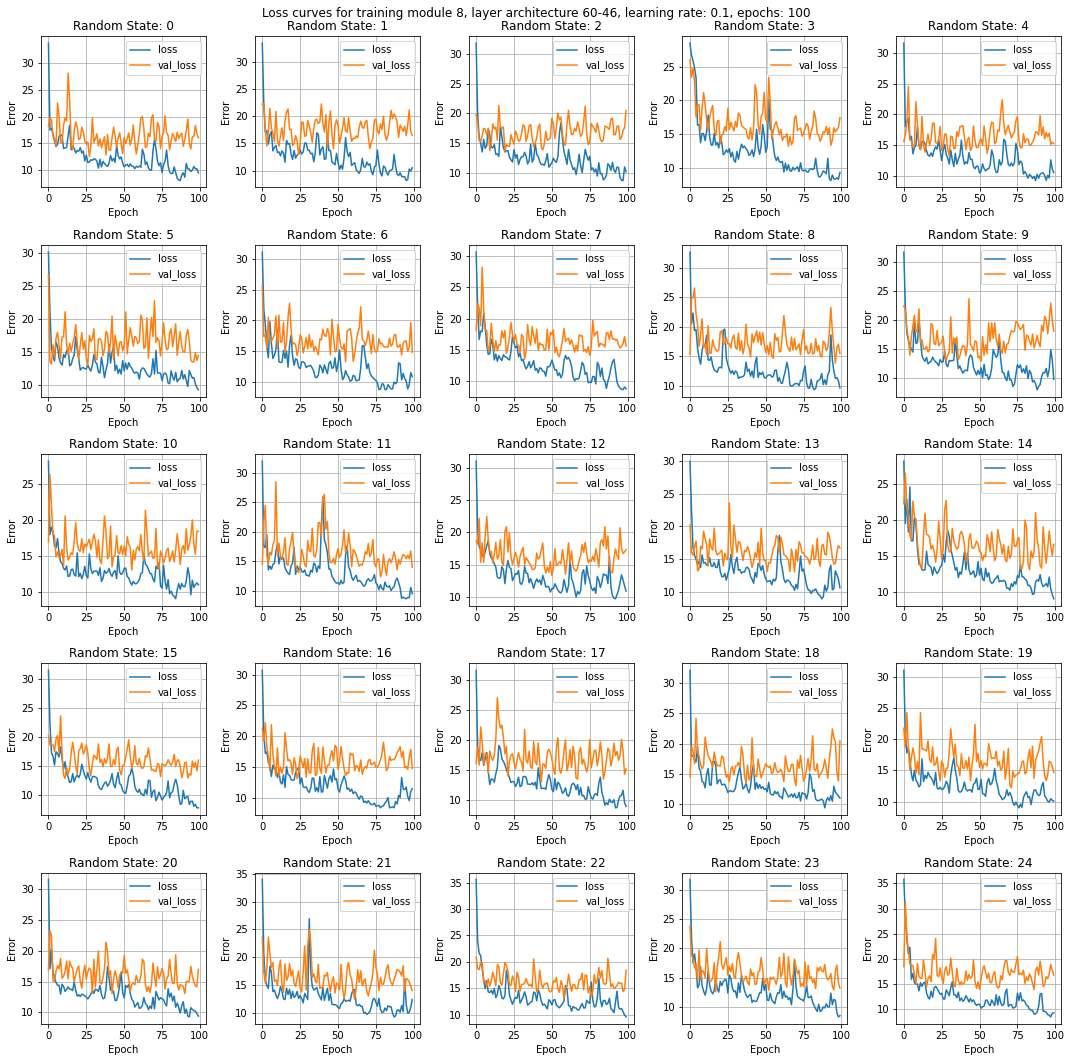

In [79]:
# load selected model loss curves

fig_dir = (
    'figs/' + 
    module + 
    '/'   
) 
isdir = os.path.isdir(fig_dir)
if isdir == False:
    os.makedirs(fig_dir)

print(arch)
print(top_learning_rate)
print(epochs)
print(dropout)

print(fig_dir)
rootdir = 'saved_results/' + res + '/sr_' + arch + '/'
print(rootdir)
dnn_history = {}
fig,ax=plt.subplots(1,1,figsize=(15,15))
fig.patch.set_facecolor('w')
fig.suptitle('Loss curves for training module ' + training_module +
             ', layer architecture ' + 
             arch + ', learning rate: ' + str(top_learning_rate) + ', epochs: ' + str(epochs) 
             )
for n, rs in enumerate(RS): 
    ax = plt.subplot(5,5,n+1)
    history_name = (
        arch + 
        '_' +
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    model_name = (
        dataset.name +
        '_' +
        str(dropout) +
        '_dnn_history_MULTI_' +
        str(top_learning_rate) +
        '_0.2_' +
        str(epochs) + 
        '_' + 
        str(rs)
    )
    
    dnn_history[model_name] = pd.read_csv(rootdir + model_name)

    ax.set_title('Random State: ' + str(rs))
    gl.plot_loss(dnn_history[model_name])
    
file_name_1 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.eps'
)

file_name_2 = (
    fig_dir +
    'loss_' +
    arch + '_' +
    dataset.name + '_' +
    str(dropout) + '_' +
    str(top_learning_rate) + '_' +
    str(epochs) +
    '.png'
)

plt.tight_layout()
# fig.savefig(file_name_1)
fig.savefig(file_name_2)


In [52]:
predictions = gl.predictions_finder()
predictions

100%|██████████| 96/96 [00:00<00:00, 127.68it/s]


,architecture,epochs,learning rate,training module
0,50-28,100,0.1,3
0,24-12,100,0.1,3
0,64-48,100,0.1,3
0,59-28,100,0.1,3


In [9]:
idx = 0
training_module =  predictions['training module'].iloc[idx]
architecture = predictions['architecture'].iloc[idx]
learning_rate = predictions['learning rate'].iloc[idx]
epochs = predictions['epochs'].iloc[idx]
df = gl.predictions_loader(
    training_module = training_module,
    architecture = architecture,
    learning_rate = learning_rate,
    epochs = epochs
    
)

gl.glathida_stats_adder(
    df,
#     pth_1 = '/home/simonhans/data/prethicktor/regional_data/raw/',
#     pth_2 = '/home/simonhans/data/prethicktor/RGI/rgi60-attribs/',
#     pth_3 = '/home/simonhans/data/prethicktor/regional_data/training_data/',
)
df

100%|██████████| 15/15 [00:00<00:00, 371.09it/s]


,vol,Area_RGI_iqr,Area_RGI_mean,Area_RGI_median,Area_RGI_std,Aspect_RGI_iqr,Aspect_RGI_mean,Aspect_RGI_median,Aspect_RGI_std,Lmax_RGI_iqr,Lmax_RGI_mean,Lmax_RGI_median,Lmax_RGI_std,Slope_RGI_iqr,Slope_RGI_mean,Slope_RGI_median,Slope_RGI_std,Zmax_RGI_iqr,Zmax_RGI_mean,Zmax_RGI_median,Zmax_RGI_std,Zmin_RGI_iqr,Zmin_RGI_mean,Zmin_RGI_median,Zmin_RGI_std,architecture,area,dataframe,epochs,h mean f,learning rate,region,tolerance,total variance,volf,mean thickness,voldiff,Area_GlaThiDa_mean,Aspect_GlaThiDa_mean,Lmax_GlaThiDa_mean,Slope_GlaThiDa_mean,Zmin_GlaThiDa_mean,Zmax_GlaThiDa_mean,Area_GlaThiDa_median,Aspect_GlaThiDa_median,Lmax_GlaThiDa_median,Slope_GlaThiDa_median,Zmin_GlaThiDa_median,Zmax_GlaThiDa_median,Area_GlaThiDa_std,Aspect_GlaThiDa_std,Lmax_GlaThiDa_std,Slope_GlaThiDa_std,Zmin_GlaThiDa_std,Zmax_GlaThiDa_std,ratio trainable,vol_ratio,vol_from_zero
0,11.971913,0.68100,3.199242,0.3130,41.810153,234.00,192.250848,215.0,119.556115,1079.00,1532.236388,744.0,4166.345049,9.00,24.023993,23.00,7.280360,609.00,1816.157186,1797.0,554.464460,626.0,1337.327542,1334.0,500.317301,50-28,86725.053,df7_01,100,218.0,0.100,01,4.92,10.673079,18.98,138.044454,-7.008087,31.746125,178.125000,7208.750000,18.625000,1505.125000,2278.000000,1.8260,206.0,2351.0,21.00,1579.5,2554.0,76.730266,116.309326,13254.758068,5.452924,735.136116,800.062341,0.000295,0.630765,0.369235
1,1.538855,0.47200,0.770312,0.1820,4.561523,260.00,153.637072,103.0,127.722660,699.00,907.091806,567.0,1219.842485,9.50,24.509075,24.20,7.448535,678.00,2418.342668,2348.0,575.395510,651.0,2075.797666,1974.0,620.405019,50-28,14524.224,df7_02,100,72.0,0.100,02,0.27,8.179932,1.06,105.950909,0.478855,2.062406,168.531250,2526.000000,21.178125,2241.687500,3116.937500,1.1850,162.5,2138.0,20.80,2007.5,3011.0,3.074268,120.333387,2238.034517,5.621317,601.644384,608.579182,0.001697,1.451750,0.451750
2,15.218515,6.79175,23.110887,1.7665,124.489082,240.00,181.664028,183.0,120.751525,3503.25,4470.662929,1890.0,7968.824606,7.70,15.436148,14.35,6.115374,486.50,1053.961961,1059.0,367.481644,417.0,510.091689,524.5,292.298323,50-28,105108.312,df7_03,100,270.0,0.100,03,7.35,4.520922,28.33,144.788879,-13.111485,1238.533333,259.000000,54630.333333,6.100000,16.000000,1419.666667,999.8610,323.0,71606.0,6.30,0.0,1921.0,1046.519763,92.639085,32082.883332,0.509902,22.627417,819.563434,0.000658,0.537187,0.462813
3,4.216965,2.14750,5.514259,0.6570,43.879279,236.00,172.181254,163.0,120.474964,1924.50,2331.581389,1191.0,3683.474811,7.10,17.700000,16.90,5.800160,447.50,1119.713554,1120.0,315.732986,389.0,700.133378,695.0,303.851676,50-28,40888.228,df7_04,100,210.0,0.100,04,2.23,4.801514,8.61,103.133970,-4.393035,1479.180000,30.500000,31318.000000,7.300000,420.500000,1452.000000,1479.1800,30.5,31318.0,7.30,420.5,1452.0,1292.232000,20.500000,1445.000000,3.700000,17.500000,335.000000,0.000270,0.489775,0.510225
4,26.393191,1.70625,6.421827,0.3930,79.452633,216.00,179.796711,177.0,114.465345,1608.00,2042.748667,838.0,3956.978654,12.90,20.433266,19.60,9.216535,667.00,1253.893344,1221.0,488.323296,610.0,781.590460,761.0,436.168658,50-28,130054.846,df7_05,100,175.0,0.100,05,4.07,8.032514,15.69,202.938930,10.703191,20.154000,261.000000,8083.000000,11.300000,159.000000,983.000000,20.1540,261.0,8083.0,11.30,159.0,983.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000049,1.682166,0.682166
5,1.620819,2.58100,19.505422,0.5690,117.108721,229.00,170.499118,152.0,117.692026,2095.00,3148.227513,987.0,6825.961018,8.60,17.620459,16.70,6.571902,244.50,1295.209877,1267.0,247.578356,267.5,892.552028,936.0,252.231364,50-28,11059.574,df7_06,100,341.0,0.100,06,0.98,1.554516,3.77,146.553475,-2.149181,608.658000,142.000000,28302.666667,11.366667,477.666667,1511.000000,264.5360,117.0,22676.0,7.30,607.0,1762.0,682.150351,41.880783,25153.662349,7.512360,262.994719,499.241425,0.005282,0.429925,0.570075
6,3.535625,7.09350,21.027204,1.8740,78.127422,234.00,174.302167,164.0,120.216076,3937.50,4961.415480,2471.0,6949.757330,6.70,14.9239

In [92]:
# compute residuals
residuals = df[[
    'dataframe',
    'vol_ratio',
    'vol_from_zero',
    'voldiff',
]]

residuals['percent error'] = abs(
   ( 1 - residuals['vol_ratio']) * 100
)
residuals['region'] = residuals['dataframe'].str[4:]
residuals = residuals.drop('dataframe', axis = 1)
residuals.sort_values('percent error')

,vol_ratio,vol_from_zero,voldiff,percent error,region
13,1.059021,0.059021,0.169390,5.902076,14
18,0.897637,0.102363,-4.756812,10.236307,19
7,0.886788,0.113212,-0.033964,11.321225,08
16,0.879793,0.120207,-0.641904,12.020671,17
12,1.264182,0.264182,0.863874,26.418162,13
0,0.630765,0.369235,-7.008087,36.923537,01
14,1.427109,0.427109,0.375856,42.710857,15
1,1.451750,0.451750,0.478855,45.174975,02
2,0.537187,0.462813,-13.111485,46.281275,03
10,1.486597,0.486597,0.063258,48.659728,11
